# Data wrangling and database population

In [1]:
#import statements
import pandas as pd
from unidecode import unidecode

In [2]:
#assign path for excel file upload
excel_file_path = "C:/Users/mfosg/Downloads/Marine Mammals Global Species Database (1).xlsx"

In [3]:
#read in hierarchy data
hierarchy_df = pd.read_excel(excel_file_path, sheet_name="Marine Mammals", usecols=['taxonid', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'friendly_name', 'category'])
hierarchy_df.head()

,taxonid,kingdom,phylum,class,order,family,genus,species,friendly_name,category
0,17026,ANIMALIA,CHORDATA,MAMMALIA,CARNIVORA,OTARIIDAE,Phocarctos,hookeri,Phocarctos hookeri,EN
1,22103,ANIMALIA,CHORDATA,MAMMALIA,SIRENIA,TRICHECHIDAE,Trichechus,manatus,Trichechus manatus,VU
2,10303,ANIMALIA,CHORDATA,MAMMALIA,SIRENIA,DUGONGIDAE,Hydrodamalis,gigas,Hydrodamalis gigas,EX
3,22102,ANIMALIA,CHORDATA,MAMMALIA,SIRENIA,TRICHECHIDAE,Trichechus,inunguis,Trichechus inunguis,VU
4,4162,ANIMALIA,CHORDATA,MAMMALIA,CETARTIODACTYLA,DELPHINIDAE,Cephalorhynchus,hectori,Cephalorhynchus hectori,EN


In [4]:
#read in country occurrence data
countries_df = pd.read_excel(excel_file_path, sheet_name="Country Occurances", usecols=['taxonid', 'countryoccurrencelookup_value'])
countries_df.fillna("Unknown", inplace=True)
countries_df.head()

,taxonid,countryoccurrencelookup_value
0,1793,NE Niger
1,1793,GH Ghana
2,1793,AO Angola
3,1793,CM Cameroon
4,1793,NA Namibia


In [5]:
#create hierarchy df by copying columns and printing out info
hierarchy = hierarchy_df[['taxonid','family', 'genus', 'species', 'friendly_name', 'category']].copy()
#rename columns and convert category values to upper
hierarchy = hierarchy.rename(columns={'family': 'fName', 'genus': 'gName','species': 'sName'})
hierarchy['category'] = hierarchy['category'].str.upper()

In [6]:
#use unidecode to exclude any special characters or letter accents
countries_df['countryoccurrencelookup_value'] = countries_df['countryoccurrencelookup_value'].str.replace(r'[^\w\s]+', '', regex=True)
countries_df['countryoccurrencelookup_value'] = countries_df['countryoccurrencelookup_value'].apply(lambda x: unidecode(str(x)))

In [7]:
#convert dataframes to csv files
hierarchy.to_csv('hierarchy.csv', index=False)
countries_df.to_csv('countries.csv', index=False)

In [8]:
#merge dataframes
df = pd.merge(hierarchy, countries_df, on='taxonid')
df = df.rename(columns={'family': 'fName', 'genus': 'gName','species': 'sName'})

In [9]:
#convert merged dataframe to a csv file
df.to_csv('IUCNRedList.csv', index=False)

# Querying the database

The query we are interested in visualizing is the number of all the threatened species per family.

The MySQL Workbench image below shows a view that joins the species and the family tables, filters on the category column to only include threatened species, groups the results by family and then counts the number of threatened species in each family

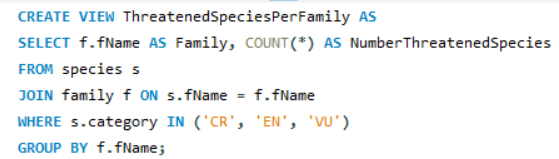

In [10]:
#import statements
import matplotlib.pyplot as plt

In [11]:
#read in the threatenedspecies from csv
threatened_species = pd.read_csv('threatenedSpeciesPerFamily.csv')
threatened_species.head()

,Family,NumberThreatenedSpecies
0,OTARIIDAE,5
1,BALAENOPTERIDAE,3
2,DELPHINIDAE,8
3,PHOCIDAE,4
4,DUGONGIDAE,1


# Visualizing the data

In [12]:
#group by family and count threatened species
threatened_species_count = threatened_species.groupby('Family').agg({'NumberThreatenedSpecies': 'sum'})

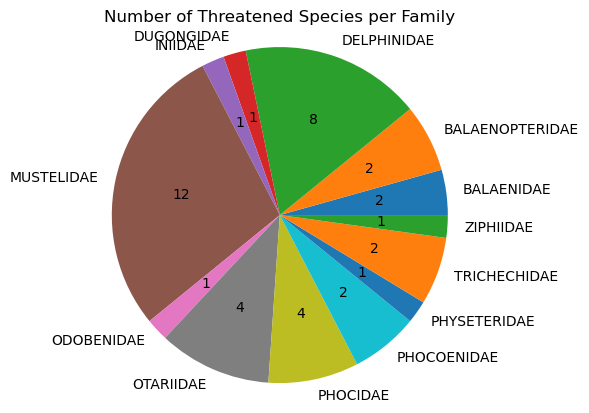

In [13]:
#plot pie chart
plt.pie(threatened_species_count['NumberThreatenedSpecies'], labels=threatened_species_count.index, autopct=lambda x: f"{int(x * threatened_species_count['NumberThreatenedSpecies'].sum() / 100)}")
plt.axis('equal')
plt.title('Number of Threatened Species per Family')
plt.show()

# Taking this a step further (:

After observing the above visualization, it becomes obvious that the organisms in the Mustelidae family have the largest number of threatened species compared to the other marine mammal families. 

From this understanding, I would like to do a second query that looks at how many species there are in the family Mustelidae to get a better understanding of the percentage of their threatened vs non-threatened species.

The query below was created using MySQL workbench again uses the database populated earlier to populate a view that shows the number of total species versus threatened species in the family Mustelidae.

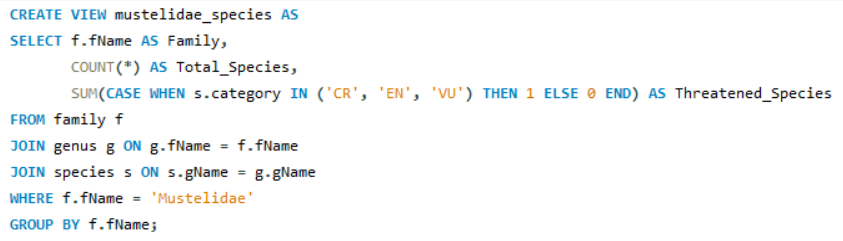

In [14]:
#load the data from the CSV file
df = pd.read_csv('mustelidae_threatened.csv')

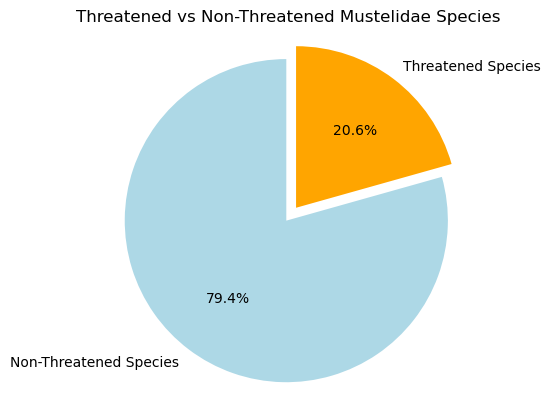

In [15]:
#create a pie chart
labels = ['Non-Threatened Species', 'Threatened Species']
sizes = [df['Total_Species'].iloc[0] - df['Threatened_Species'].iloc[0], df['Threatened_Species'].iloc[0]]
colors = ['lightblue', 'orange']
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

plt.title('Threatened vs Non-Threatened Mustelidae Species')

plt.show()
